In [1]:
from google.colab import drive
drive.mount('/content/drive')  #listになかったのでドライブ上にデータ保存し、ドライブをマウント。

Mounted at /content/drive


In [2]:
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.4 MB/s eta 0:00:00


In [3]:
### その他
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from optuna import integration, logging

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
def tune_lgbm_params(train, cols_exp, col_target):
    params = {
       "random_seed": 0,
       "objective": 'binary',
       "metric": "binary_logloss",
       'verbose': -1
    }

    x = train[cols_exp].to_numpy()
    y = train[col_target].to_numpy()

    # dataset
    train_set = integration.lightgbm.Dataset(x, y)

    # tuning with optuna
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    tuner = integration.lightgbm.LightGBMTunerCV(params=params,
                                                train_set=train_set,
                                                num_boost_round=100,
                                                # num_boost_round=5,
                                                folds=kf)

    logging.set_verbosity(logging.WARNING)
    tuner.run()

    params_tuned = tuner.best_params
    return params_tuned

In [6]:
def train_lgbm(train, cols_exp, col_target, params=None):

    if params is None:
        params = {}

    params_add = {
       "n_estimators": 10000,
       "objective": 'binary',
       "metric": "binary_logloss",
    }
    params |= params_add

    x = train[cols_exp].to_numpy()
    y = train[col_target].to_numpy()

    # クラス不均衡を考慮した重みの計算
    # 正例が90%なので、負例に高い重みをつける
    weights = np.where(y == 0, 9, 1)  # 負例に重み9、正例に重み1を設定

    # K-fold
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    y_valid_pred_lst = []
    idx_valid_lst = []
    clf_lst = []

    # cross validation
    for fold, (idx_train, idx_valid) in enumerate(kf.split(x)):
        print("fold", fold)
        x_train = x[idx_train, :]
        x_valid = x[idx_valid, :]
        y_train = y[idx_train]
        y_valid = y[idx_valid]

        # lightgbm modeling
        clf = lgbm.LGBMClassifier(**params)
        clf.fit(x_train, y_train,
                eval_set=[(x_train, y_train), (x_valid, y_valid)],
                callbacks=[
                    lgbm.early_stopping(stopping_rounds=50),
                    lgbm.log_evaluation(period=10000),
                ])

        # oof
        y_valid_pred = clf.predict_proba(x_valid)
        y_valid_pred_lst.append(y_valid_pred)
        idx_valid_lst.append(idx_valid)
        clf_lst.append(clf)

    idx_valid = np.hstack(idx_valid_lst)
    y_valid_pred = np.vstack(y_valid_pred_lst)
    oof_pred = y_valid_pred[np.argsort(idx_valid)]

    return clf_lst, oof_pred

In [7]:
def predict_test(x_test, clf_lst):
    y_test_pred_lst = []

    for clf in clf_lst:
        y_test_pred = clf.predict_proba(x_test)
        y_test_pred_lst.append(y_test_pred)

    y_test_pred = np.mean(y_test_pred_lst, axis=0)
    return y_test_pred

In [8]:
feat = "feat01"
train = pd.read_csv(f"/content/drive/MyDrive/signate/債務不履行/途中経過_csv/feat_train_{feat}.csv")
test = pd.read_csv(f"/content/drive/MyDrive/signate/債務不履行/途中経過_csv/feat_test_{feat}.csv")

In [9]:
train

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,MIS_Status,Sector,ApprovalFY,city,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,population,density,county_fips,city_Term_mean,city_NoEmp_mean,DisbursementGross_plus_SBA_Appv,DisbursementGross_minus_SBA_Appv,DisbursementGross_times_SBA_Appv,DisbursementGross_divided_by_SBA_Appv,SBA_Appv_plus_GrAppv,SBA_Appv_minus_GrAppv,SBA_Appv_times_GrAppv,SBA_Appv_divided_by_GrAppv,DisbursementGross_plus_GrAppv,DisbursementGross_minus_GrAppv,DisbursementGross_times_GrAppv,DisbursementGross_divided_by_GrAppv,lr_avg_ppi,outlier,DisbursementDate_timestamp,ApprovalDate_timestamp,LoanEnd_timestamp,ApprovalToDisbursement_days,target_FranchiseCode,target_RevLineCr,target_LowDoc,target_Sector,target_ApprovalFY,target_city,target_State,target_BankState,target_UrbanRural,target_county_fips
0,163,21,1.0,0,0,1,1,3,1,23,29,1724,3,41,-0.3994,-0.3800,-0.3386,0,0.9470,-0.2627,633,0.34060,0.02557,-0.3770,-0.3486,-0.24150,-0.4216,-0.3630,0.4001,-0.24660,0.6800,-0.3926,-0.0914,-0.24960,-0.2488,0.43580,0.09015,-0.55960,0.84670,0.11224,0.3533,0.919686,0.924868,0.908273,0.940289,0.876591,0.912698,0.908228,0.939937,0.945563,0.895935
1,84,6,1.0,4,0,0,0,3,1,19,15,1339,36,36,0.4329,0.4573,0.4475,0,-0.4973,-0.6074,631,0.27860,0.60200,0.4453,0.1833,-0.02570,-0.3645,0.4550,-0.3457,-0.02844,0.3804,0.4482,-0.0914,-0.02534,-0.2488,-0.38040,0.11334,-1.24200,-1.58500,-1.06200,0.4963,0.880468,0.893256,0.907312,0.890526,0.927559,1.000000,0.906921,0.916435,0.946101,1.000000
2,242,45,1.0,4,90,0,1,3,1,7,24,943,31,31,-0.5930,-0.5820,-0.5960,1,-0.4730,1.5840,994,1.43200,1.92500,-0.6020,-0.2903,-0.25900,0.3210,-0.5913,0.3508,-0.26460,-1.4180,-0.5920,-0.0578,-0.26560,-0.1290,0.13720,0.02054,0.01506,-0.08124,1.21400,0.4827,0.882409,0.923958,0.908134,0.899727,0.898455,1.000000,0.949468,0.952703,0.825198,0.912693
3,237,4,1.0,0,0,0,1,3,1,6,27,1485,42,41,0.1996,0.2227,0.4446,0,-0.0835,-0.5380,742,0.65670,0.31200,0.3147,-0.4893,-0.07370,-0.5586,0.3250,0.5970,-0.07697,1.5790,0.2125,-0.0914,-0.11370,-0.2488,-0.12230,0.11426,0.97800,0.34030,1.81800,0.5330,0.881203,0.923889,0.907469,0.913000,0.903582,0.964435,0.927489,0.941023,0.944465,0.964435
4,184,0,1.0,0,0,0,1,3,1,23,23,1762,4,4,1.3900,1.4200,1.2460,0,-0.4504,0.3010,994,-0.35330,-0.73340,1.3430,1.0490,0.47680,-0.2996,1.3480,-1.5590,0.47950,0.0807,1.4150,-0.0914,0.54500,-0.2488,-0.62350,0.06290,-2.91200,-0.30960,-1.28500,0.2402,0.880468,0.923693,0.907312,0.939921,0.920891,0.916309,0.883054,0.879085,0.946101,0.919112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42302,283,14,1.0,0,0,1,1,3,1,23,18,1723,38,38,-0.3994,-0.3800,-0.3386,0,1.5240,1.1830,700,0.72300,-0.12720,-0.3770,-0.3486,-0.24150,-0.4216,-0.3630,0.4001,-0.24660,0.6800,-0.3926,-0.0914,-0.24960,-0.2488,0.00975,0.08770,-0.55960,-1.12900,1.19500,0.5190,0.917544,0.923766,0.908344,0.940943,0.874442,0.957404,0.906085,0.883080,0.945499,0.957404
42303,53,2,1.0,0,0,0,4,3,1,7,30,1262,4,41,-0.7010,-0.6830,-0.6490,1,3.7520,0.5870,994,-0.82370,-0.82230,-0.6865,-0.4805,-0.26070,-0.4216,-0.6710,0.5850,-0.26600,0.6800,-0.6973,-0.0914,-0.26830,-0.2488,-0.44400,0.06396,-1.65600,0.96700,-1.62000,0.2452,0.882684,0.816008,0.908344,0.898218,0.826872,0.903226,0.879636,0.941487,0.825253,0.910778
42304,59,6,2.0,0,0,1,1,3,1,7,26,460,35,35,-0.4800,-0.4610,-0.4214,0,0.0575,-0.0993,587,0.00854,-0.31960,-0.4595,-0.3838,-0.24990,-0.4216,-0.4450,0.4495,-0.25510,0.6800,-0.4739,-0.0914,-0.25780,-0.2488,1.32900,0.10560,0.25500,0.24390,-0.27660,0.4768,0.919606,0.923958,0.908134,0.899727,0.860706,0.928058,0.893253,0.875952,0.944626,0.934211
42305,295,18,1.0,0,8,0,1,3,1,7,12,432,23,23,0.4610,0.4856,0.4033,0,-0.4993,-0.7170,356,4.19500,0.78960,0.4407,0.3720,-0.02951,-0.2996,0.4504,-0.6104,-0.03232,0.0807,0.4766,-0.0914,-0.01334,-0.2488,0.17650,0.02486,-0.58250,-2.07200,1.2

In [10]:
## カテゴリ変数の抽出
cols_notcat = ['MIS_Status', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
               'DisbursementGross', 'GrAppv', 'SBA_Appv','population', 'density',
               'lr_avg_ppi','ApprovalToDisbursement_days','outlier'] # 数値特徴量 'DisbursementGross_minus_SBA_Appv'
# county_col = ['county_gdp','sector_count']
time_col = ["DisbursementDate_timestamp",	"ApprovalDate_timestamp",	"LoanEnd_timestamp"]
dissba = ['DisbursementGross_plus_SBA_Appv','DisbursementGross_minus_SBA_Appv', 'DisbursementGross_times_SBA_Appv','DisbursementGross_divided_by_SBA_Appv']
sbagr = ['SBA_Appv_plus_GrAppv','SBA_Appv_minus_GrAppv', 'SBA_Appv_times_GrAppv','SBA_Appv_divided_by_GrAppv']
disgr = ['DisbursementGross_plus_GrAppv','DisbursementGross_minus_GrAppv', 'DisbursementGross_times_GrAppv','DisbursementGross_divided_by_GrAppv']
# year_col = ["USREC_SUM"]
# urb_col = ["HOUPCT_RUR","ALAND_PCT_RUR","RUR_pct"]
city_col = ["city_Term_mean","city_NoEmp_mean"]

cols_notcat = cols_notcat + city_col + dissba + sbagr + disgr + time_col # 数値特徴量

#-------------------------------------------------------------------------------
# 全カテゴリ特徴量
cols_cat = [c for c in test.columns if c not in cols_notcat]
# ターゲットエンコ変数
target_encoded_cols = [c for c in test.columns if "target_" in c]
# ordinal cat変数
ordinal_cols_cat = [c for c in cols_cat if c not in target_encoded_cols]
#-------------------------------------------------------------------------------
"""
### ordinal_cols_catを削除
train = train.drop(ordinal_cols_cat, axis=1)
test = test.drop(ordinal_cols_cat, axis=1)
"""

# 実行

In [11]:
### 実行
tr = train.copy()
test = test.copy()

cols_exp = [c for c in test.columns if c != "idx"]

col_target = "MIS_Status"
print("col_target =", col_target, "-"*50)

# parameter tuning with optuna
params_tuned = tune_lgbm_params(tr, cols_exp, col_target)

# train LGBM model
clf_lst, oof_pred = train_lgbm(tr, cols_exp, col_target, params_tuned) #clf_lstはtrainされたモデルのリスト

# predict test with CV ensemble
y_test_pred = predict_test(test[cols_exp].to_numpy(), clf_lst)

[I 2024-02-14 15:34:02,013] A new study created in memory with name: no-name-3383117d-d322-4f3f-8e13-4b3b84348770


col_target = MIS_Status --------------------------------------------------


min_child_samples, val_score: 0.276810: 100%|##########| 5/5 [00:18<00:00,  3.80s/it]


fold 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.245072	valid_1's binary_logloss: 0.279782
fold 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.247024	valid_1's binary_logloss: 0.274102
fold 2
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.255745	valid_1's binary_logloss: 0.271403
fold 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.251136	valid_1's binary_logloss: 0.282131
fold 4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	training's binary_logloss: 0.250722	valid_1's binary_logloss: 0.275634


In [12]:
# oof_pred_dfを作成
oof_pred_df = pd.DataFrame(oof_pred, columns=[f"MIS_Status_{h}" for h in range(2)])
# test_pred_dfを作成
test_pred_df = pd.DataFrame(y_test_pred, columns=[f"MIS_Status_{h}" for h in range(2)])

In [13]:
from sklearn.metrics import f1_score

# 実際のターゲット値
y_true = train[col_target].values

# OOF予測値をクラスに変換（確率から最も高いクラスを選択）
# 二値分類の場合、0.5を閾値としてクラスを決定することが一般的です
y_oof_pred_class = (oof_pred[:, 1] > 0.5).astype(int)

# mean F1スコア（マクロ平均）を計算
mean_f1_score_macro = f1_score(y_true, y_oof_pred_class, average='macro')
print(f'Mean F1 Score (Macro): {mean_f1_score_macro}')


Mean F1 Score (Macro): 0.637313248915736


In [ ]:
"""
削除あり: 0.637
削除無し: 0.639
target_encode
"""

'\n削除あり: 0.6463182155018681\n削除無し: 0.6430509823850443\ntarget_encode\n'

In [ ]:
# save
feat = "feat01"
oof_pred_df.to_csv(f"/content/drive/MyDrive/signate/債務不履行/model_feat/oof_pred_lgbm_{feat}.csv")
test_pred_df.to_csv(f"/content/drive/MyDrive/signate/債務不履行/model_feat/test_pred_lgbm_{feat}.csv")

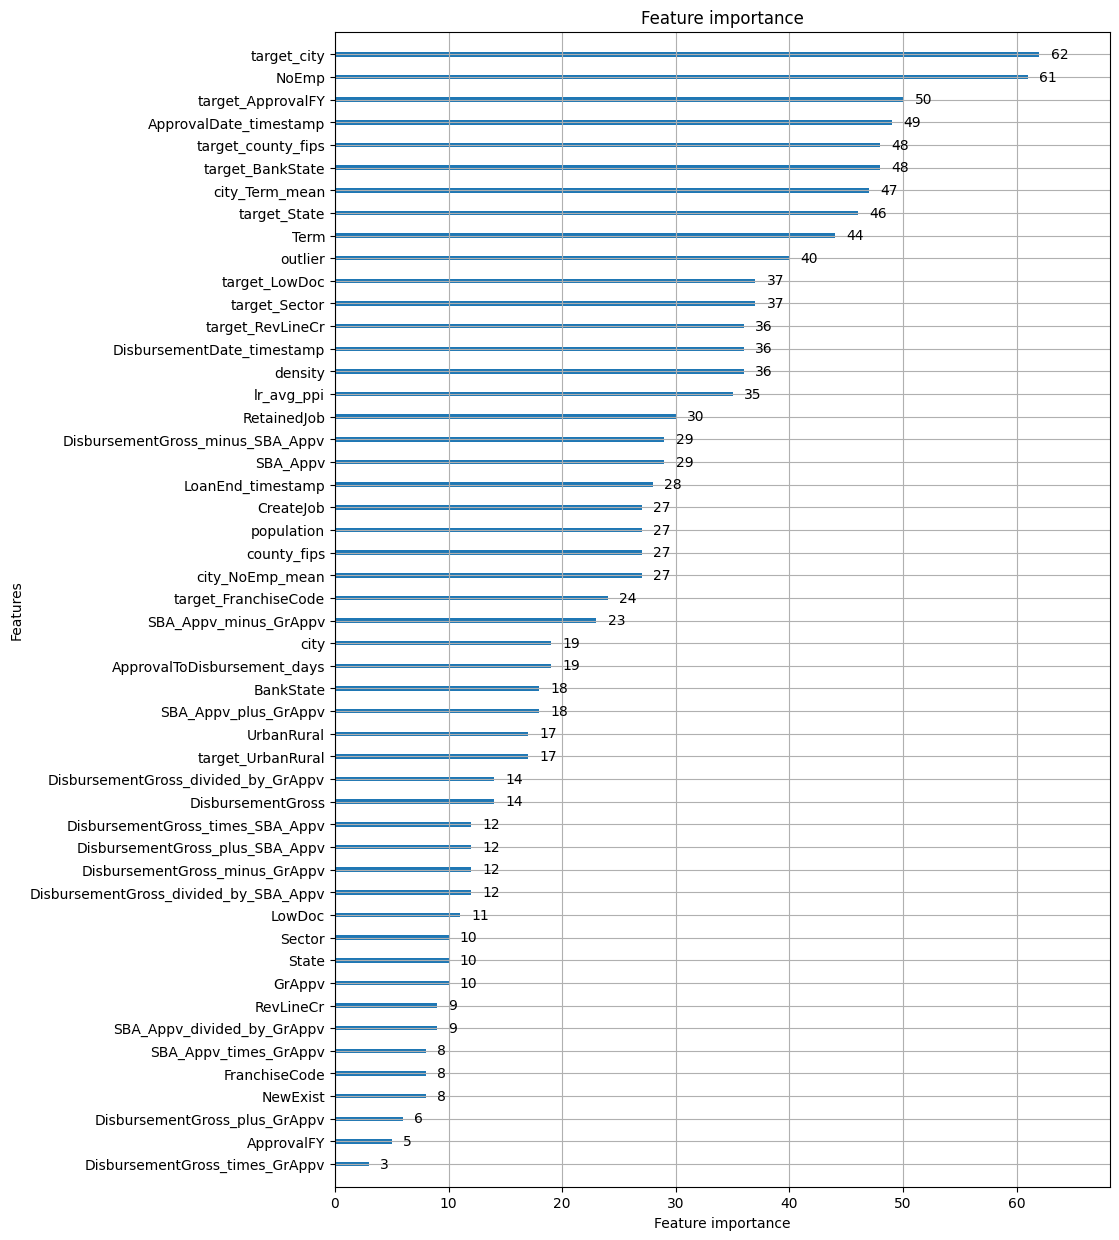

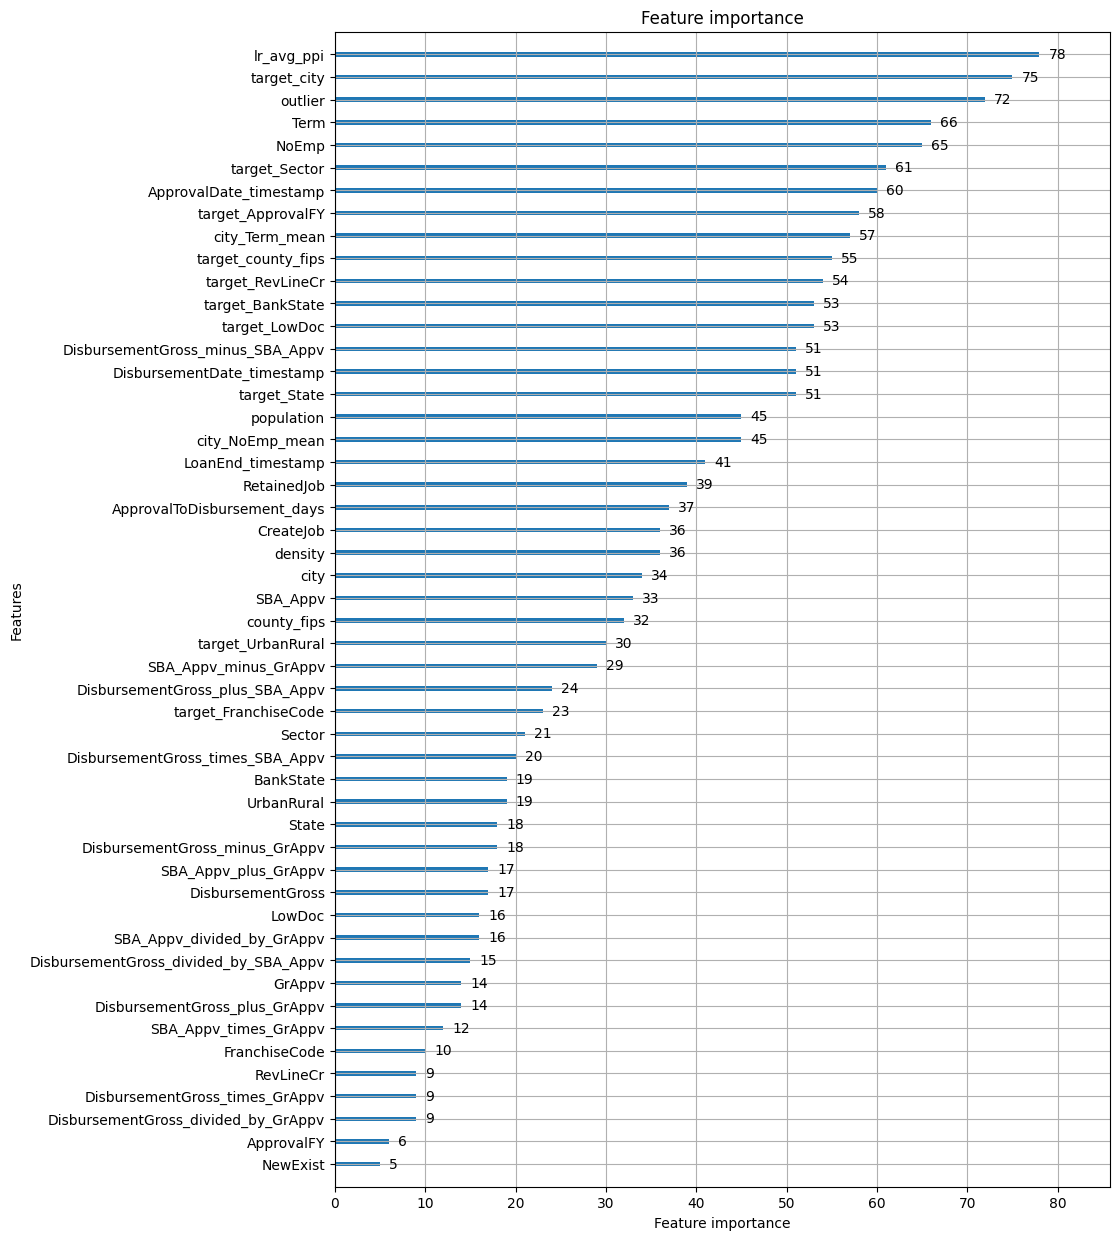

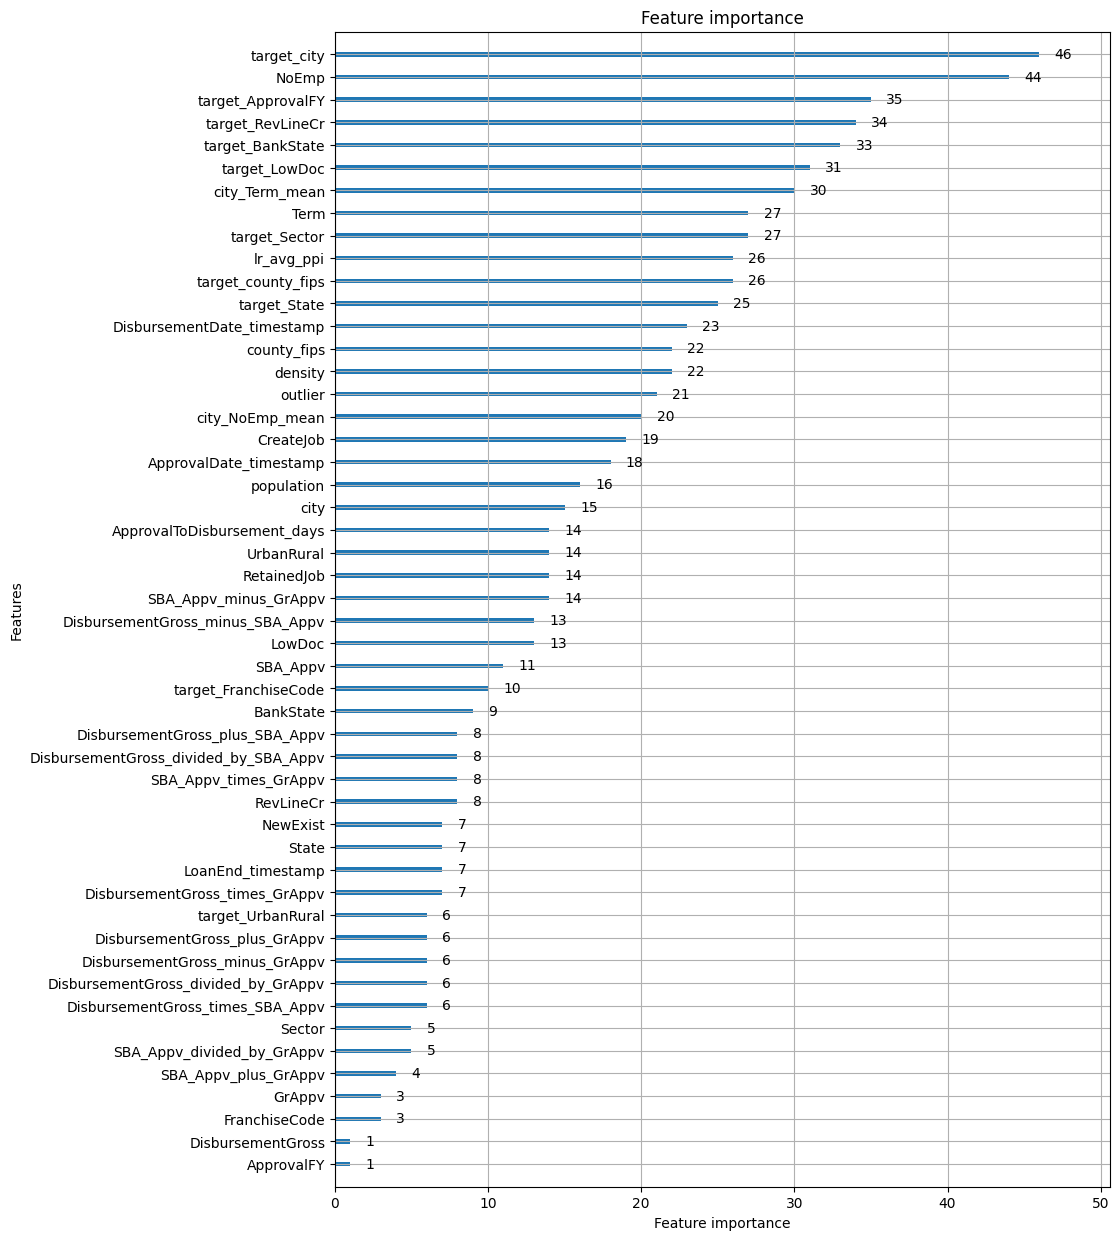

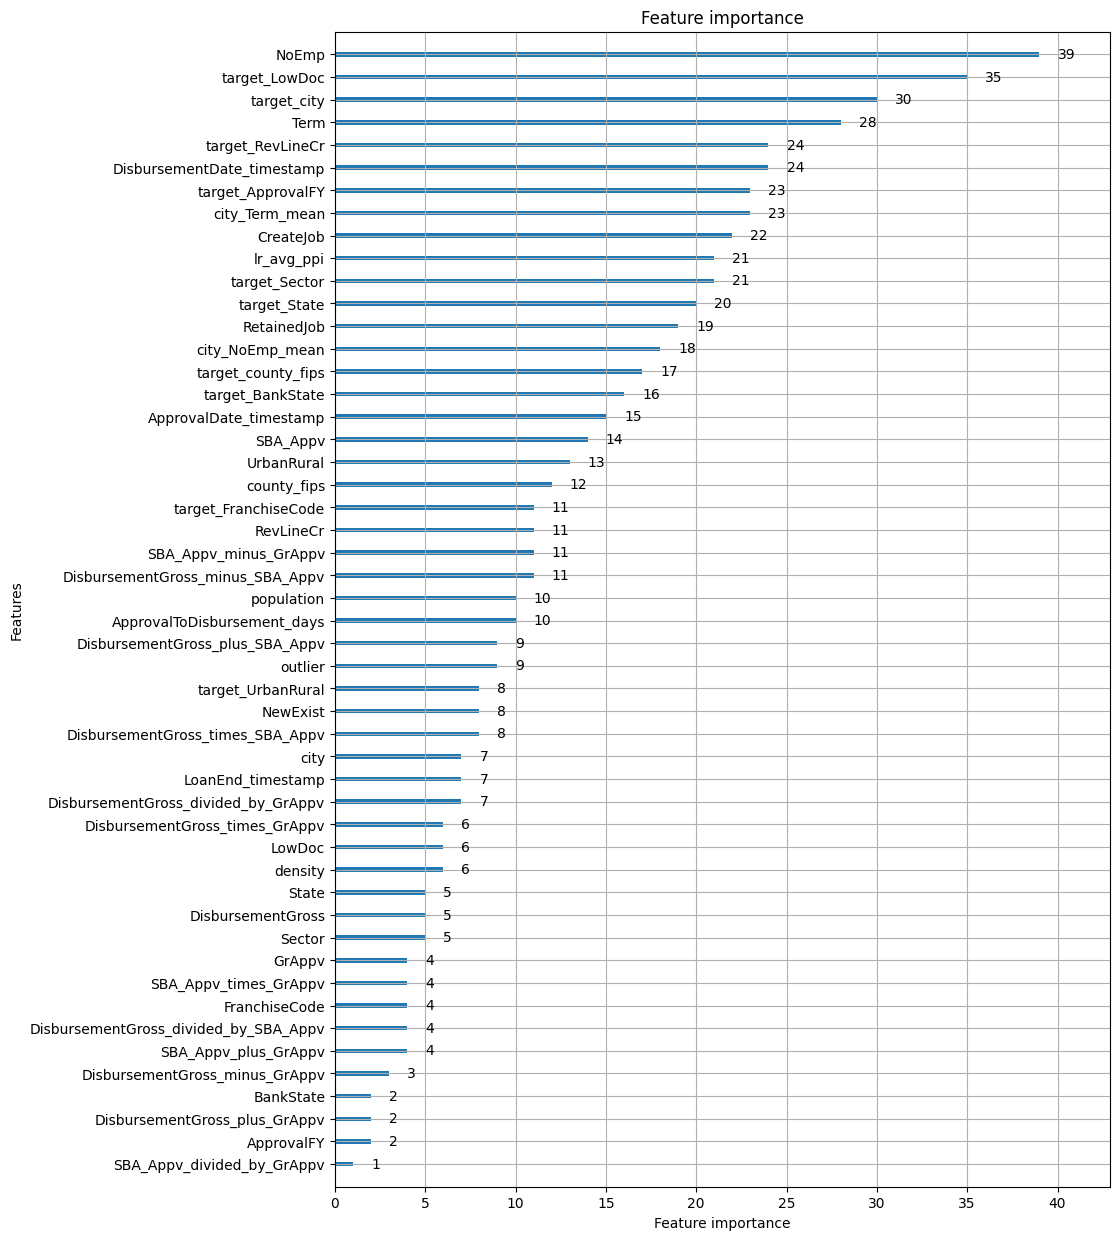

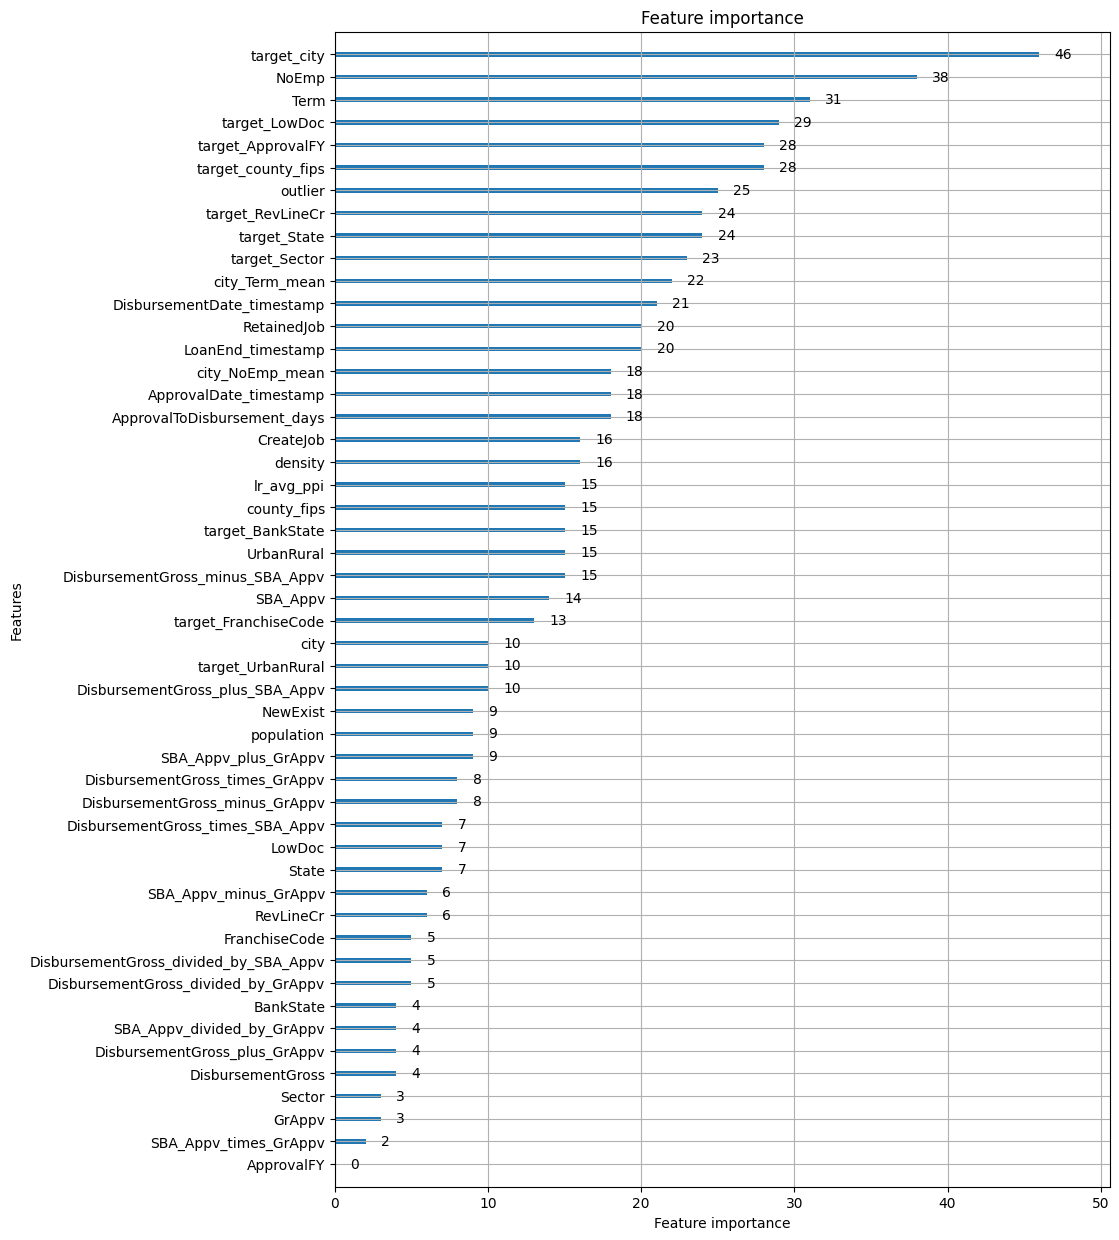

In [ ]:
### 重要度可視化
for model in clf_lst:
    fig, ax = plt.subplots(figsize=(10, 15))
    lgbm.plot_importance(model, ignore_zero=False, ax=ax)
    ax.set_yticks(np.arange(len(cols_exp)), np.array(cols_exp)[np.argsort(model.feature_importances_)])
    plt.show()
    plt.close()